<a href="https://colab.research.google.com/github/toshineb/A-and-B-test/blob/main/A_and_B_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import datetime
from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.linear_model import LinearRegression as LR
from scipy.stats import fisher_exact
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
control_data = pd.read_csv("/var/tmp/A&B/control_group.csv", sep = ";")
test_data = pd.read_csv("/var/tmp/A&B/test_group.csv", sep = ";")

In [ ]:
test_data.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [ ]:
control_data.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.00,56930.00,7016.00,2290.00,2159.00,1819.00,618.00
1,Control Campaign,2.08.2019,1757,121040.00,102513.00,8110.00,2033.00,1841.00,1219.00,511.00
2,Control Campaign,3.08.2019,2343,131711.00,110862.00,6508.00,1737.00,1549.00,1134.00,372.00
3,Control Campaign,4.08.2019,1940,72878.00,61235.00,3065.00,1042.00,982.00,1183.00,340.00
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Step 2: Organize The Data Ensure that our data is structured and clean.**

In [ ]:
# Rename columns using a dictionary
test_data.rename(columns={'Spend [USD]': 'Spend', '# of Impressions': 'Impressions', '# of Website Clicks': 'Website Clicks', '# of Searches': 'Searches', '# of View Content': 'View Content', '# of Add to Cart': 'Add to Cart', '# of Purchase': 'Purchases' }, inplace=True)
control_data.rename(columns={'Spend [USD]': 'Spend', '# of Impressions': 'Impressions', '# of Website Clicks': 'Website Clicks', '# of Searches': 'Searches', '# of View Content': 'View Content', '# of Add to Cart': 'Add to Cart', '# of Purchase': 'Purchases' }, inplace=True)

In [ ]:
# Calculate mean of each numeric column
mean_values = control_data[['Impressions', 'Reach', 'Website Clicks', 'Searches', 'View Content', 'Add to Cart', 'Purchases']].mean()

mean_values = mean_values.round(1)

# Fill NaN values in numeric columns with their means
control_data[['Impressions', 'Reach', 'Website Clicks', 'Searches', 'View Content', 'Add to Cart', 'Purchases']] = control_data[['Impressions', 'Reach', 'Website Clicks', 'Searches', 'View Content', 'Add to Cart', 'Purchases']].fillna(mean_values)

# Set display option for precision
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
control_data.head()

,Campaign Name,Date,Spend,Impressions,Reach,Website Clicks,Searches,View Content,Add to Cart,Purchases
0,Control Campaign,1.08.2019,2280,82702.00,56930.00,7016.00,2290.00,2159.00,1819.00,618.00
1,Control Campaign,2.08.2019,1757,121040.00,102513.00,8110.00,2033.00,1841.00,1219.00,511.00
2,Control Campaign,3.08.2019,2343,131711.00,110862.00,6508.00,1737.00,1549.00,1134.00,372.00
3,Control Campaign,4.08.2019,1940,72878.00,61235.00,3065.00,1042.00,982.00,1183.00,340.00
4,Control Campaign,5.08.2019,1835,109559.80,88844.90,5320.80,2221.30,1943.80,1300.00,522.80


In [ ]:
control_data.describe()

,Spend,Impressions,Reach,Website Clicks,Searches,View Content,Add to Cart,Purchases
count,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00
mean,2288.43,109559.76,88844.93,5320.79,2221.31,1943.79,1300.00,522.79
std,367.33,21311.70,21452.63,1726.80,851.03,764.02,400.37,181.81
min,1757.00,71274.00,42859.00,2277.00,1001.00,848.00,442.00,222.00
25%,1945.50,95191.25,75300.25,4122.25,1629.25,1249.00,942.50,375.50
50%,2299.50,112368.00,91418.00,5272.40,2340.00,1979.50,1319.50,506.00
75%,2532.00,121259.00,101958.75,6609.50,2655.00,2360.50,1638.00,663.25
max,3083.00,145248.00,127852.00,8137.00,4891.00,4219.00,1913.00,800.00


In [ ]:
test_data.describe()

,Spend,Impressions,Reach,Website Clicks,Searches,View Content,Add to Cart,Purchases
count,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00
mean,2563.07,74584.80,53491.57,6032.33,2418.97,1858.00,881.53,521.23
std,348.69,32121.38,28795.78,1708.57,388.74,597.65,347.58,211.05
min,1968.00,22521.00,10598.00,3038.00,1854.00,858.00,278.00,238.00
25%,2324.50,47541.25,31516.25,4407.00,2043.00,1320.00,582.50,298.00
50%,2584.00,68853.50,44219.50,6242.50,2395.50,1881.00,974.00,500.00
75%,2836.25,99500.00,78778.75,7604.75,2801.25,2412.00,1148.50,701.00
max,3112.00,133771.00,109834.00,8264.00,2978.00,2801.00,1391.00,890.00


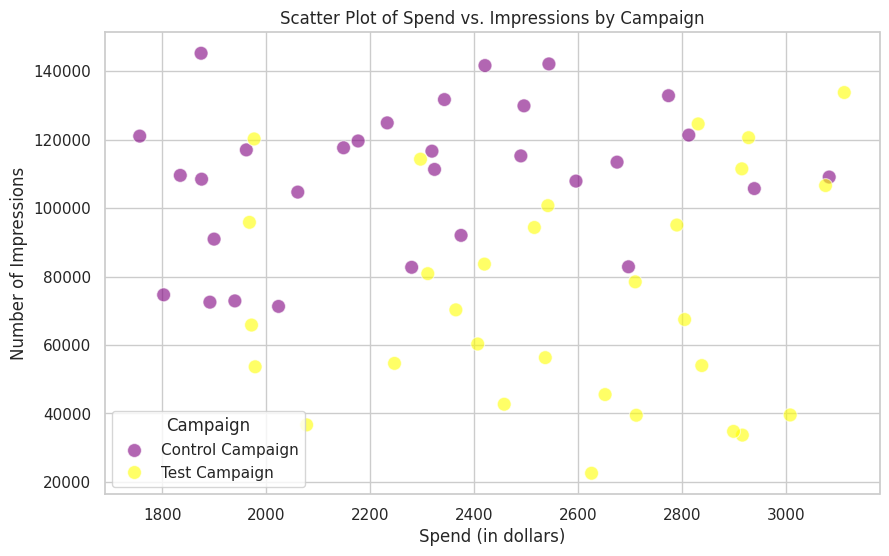

In [ ]:
combined_data = pd.concat([control_data, test_data])

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Scatter plot for Spend vs. Impressions
sns.scatterplot(x='Spend', y='Impressions', hue='Campaign Name', data=combined_data, palette=['purple', 'yellow'], s=100, alpha=0.6)

# Add titles and labels
plt.title('Scatter Plot of Spend vs. Impressions by Campaign')
plt.xlabel('Spend (in dollars)')
plt.ylabel('Number of Impressions')
plt.legend(title='Campaign')

# Show the plot
plt.show()

More spendings and less impressions in Test Campaign in comparison with Control Campaign

**Step 3:** Calculate Metrics for Each Campaign

In [ ]:
test_data["CR"] = (test_data["Purchases"]/test_data['Website Clicks']).round(2)
test_data["CPC"] = (test_data["Spend"]/test_data['Website Clicks']).round(2)
test_data["CPP"] = (test_data["Spend"]/test_data['Purchases']).round(2)
test_data["CTR"] = (test_data["Website Clicks"]/test_data['Impressions']).round(2)
test_data.head()

,Campaign Name,Date,Spend,Impressions,Reach,Website Clicks,Searches,View Content,Add to Cart,Purchases,CR,CPC,CPP,CTR
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255,0.08,0.99,11.80,0.08
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677,0.15,0.55,3.75,0.05
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578,0.07,0.30,4.09,0.11
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340,0.08,0.64,7.97,0.05
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768,0.13,0.39,2.99,0.05


In [ ]:
control_data["CR"] = (control_data["Purchases"]/control_data['Website Clicks']).round(2)
control_data["CPC"] = (control_data["Spend"]/control_data['Website Clicks']).round(2)
control_data["CPP"] = (control_data["Spend"]/control_data['Purchases']).round(2)
control_data["CTR"] = (control_data["Website Clicks"]/control_data['Impressions']).round(2)
control_data.head()

,Campaign Name,Date,Spend,Impressions,Reach,Website Clicks,Searches,View Content,Add to Cart,Purchases,CR,CPC,CPP,CTR
0,Control Campaign,1.08.2019,2280,82702.00,56930.00,7016.00,2290.00,2159.00,1819.00,618.00,0.09,0.32,3.69,0.08
1,Control Campaign,2.08.2019,1757,121040.00,102513.00,8110.00,2033.00,1841.00,1219.00,511.00,0.06,0.22,3.44,0.07
2,Control Campaign,3.08.2019,2343,131711.00,110862.00,6508.00,1737.00,1549.00,1134.00,372.00,0.06,0.36,6.30,0.05
3,Control Campaign,4.08.2019,1940,72878.00,61235.00,3065.00,1042.00,982.00,1183.00,340.00,0.11,0.63,5.71,0.04
4,Control Campaign,5.08.2019,1835,109559.80,88844.90,5320.80,2221.30,1943.80,1300.00,522.80,0.10,0.34,3.51,0.05


<ipython-input-63-4ec9bc9df51f>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Campaign Type', y='Metric Value', data=combined_data, palette=['#5B84B1FF', '#FC766AFF'])


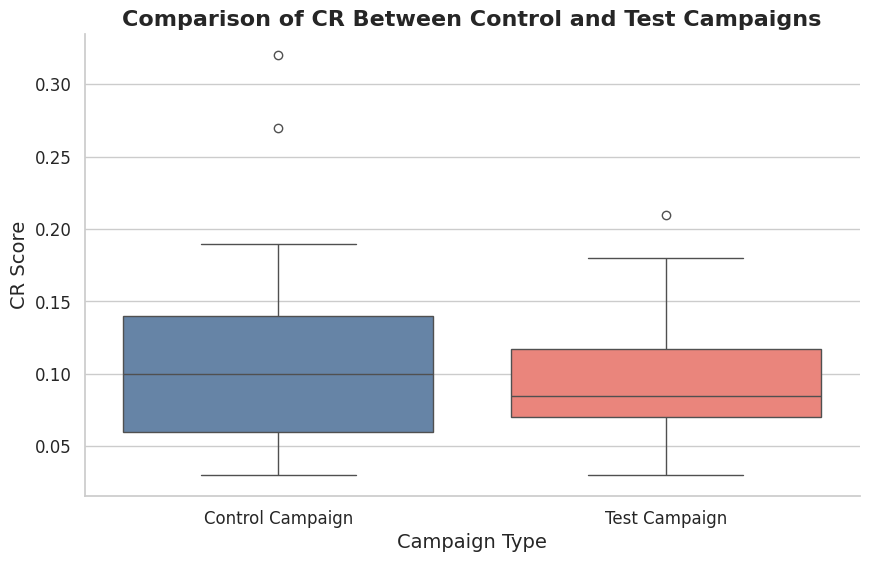

<ipython-input-63-4ec9bc9df51f>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Campaign Type', y='Metric Value', data=combined_data, palette=['#5B84B1FF', '#FC766AFF'])


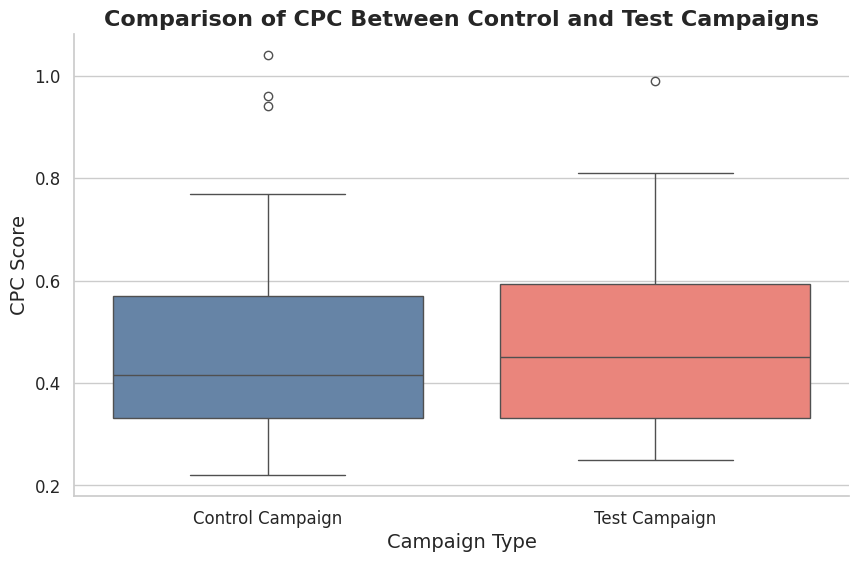

<ipython-input-63-4ec9bc9df51f>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Campaign Type', y='Metric Value', data=combined_data, palette=['#5B84B1FF', '#FC766AFF'])


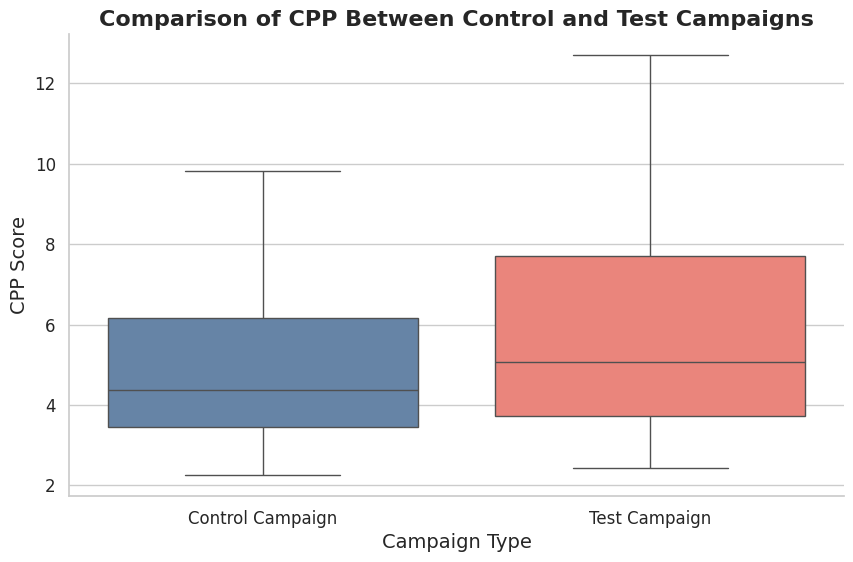

<ipython-input-63-4ec9bc9df51f>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Campaign Type', y='Metric Value', data=combined_data, palette=['#5B84B1FF', '#FC766AFF'])


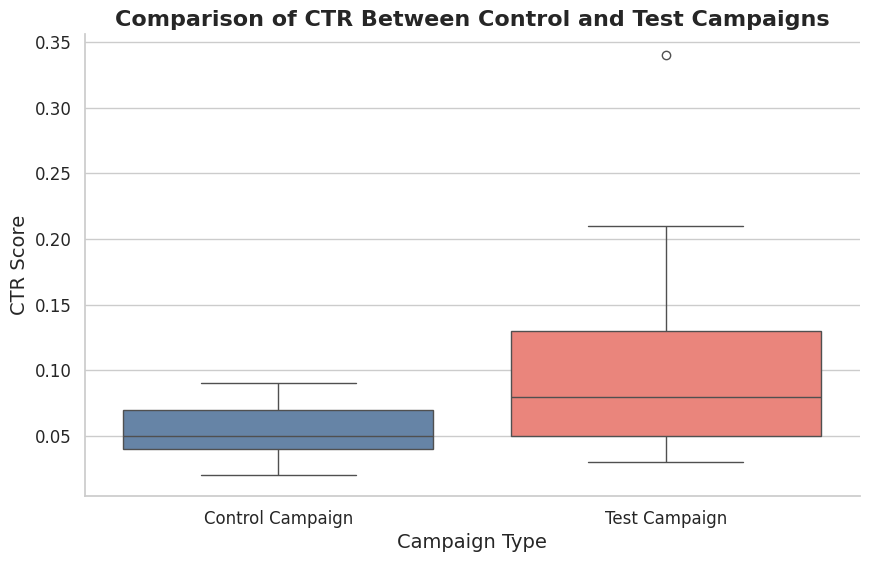

In [ ]:
metrics = ['CR', 'CPC', 'CPP', 'CTR']

# Set the overall style of the plots
sns.set_style("whitegrid")

# Loop through each metric
for metric in metrics:
    # Combine data into a single DataFrame
    combined_data = pd.DataFrame({
        'Metric Value': control_data[metric].tolist() + test_data[metric].tolist(),
        'Campaign Type': ['Control Campaign'] * len(control_data[metric]) + ['Test Campaign'] * len(test_data[metric])
    })

    # Set up the matplotlib figure with appropriate size
    plt.figure(figsize=(10, 6))

    # Box Plot
    sns.boxplot(x='Campaign Type', y='Metric Value', data=combined_data, palette=['#5B84B1FF', '#FC766AFF'])

    # Customize plot
    plt.title(f'Comparison of {metric} Between Control and Test Campaigns', fontsize=16, fontweight='bold')
    plt.xlabel('Campaign Type', fontsize=14)
    plt.ylabel(f'{metric} Score', fontsize=14)

    # Improve tick parameters for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Optionally, remove the top and right spines (for a cleaner look)
    sns.despine()

    # Display the plot
    plt.show()

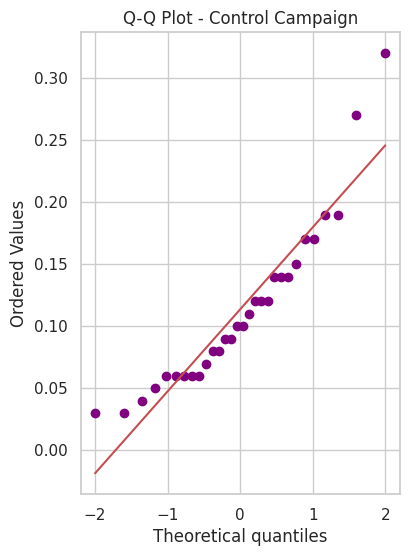

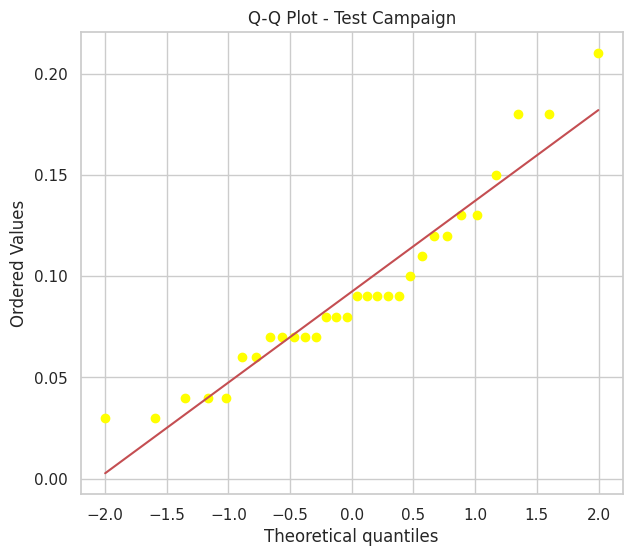

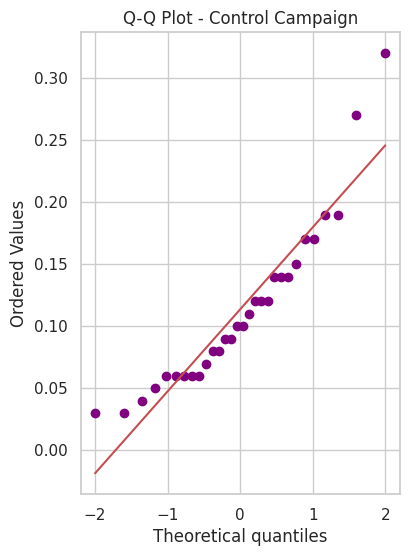

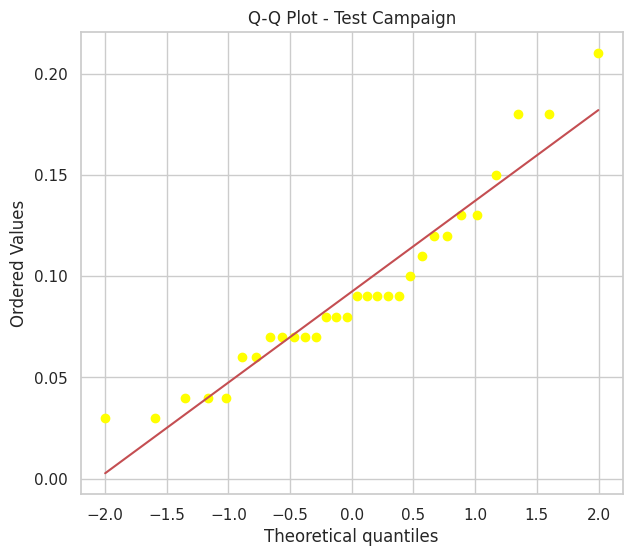

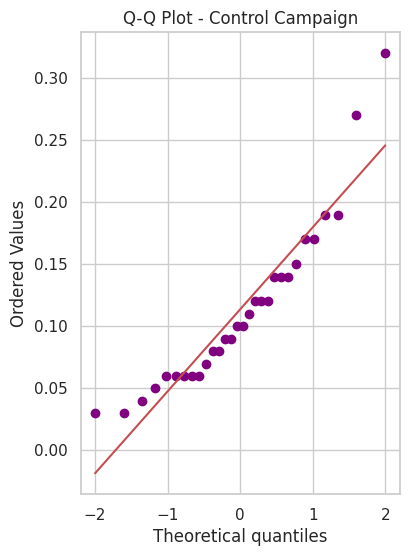

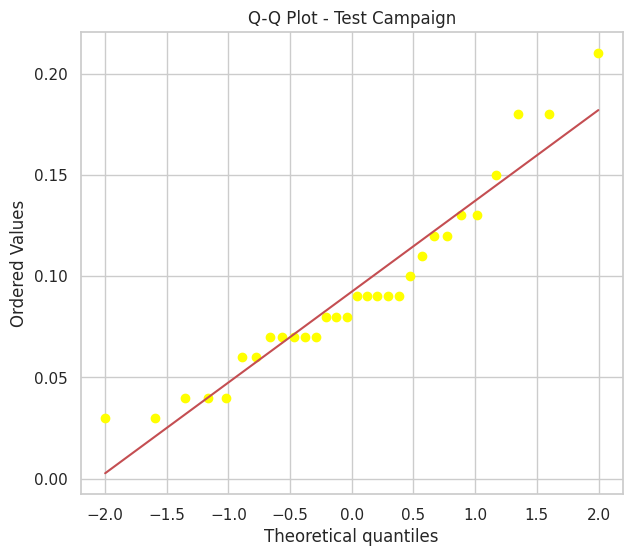

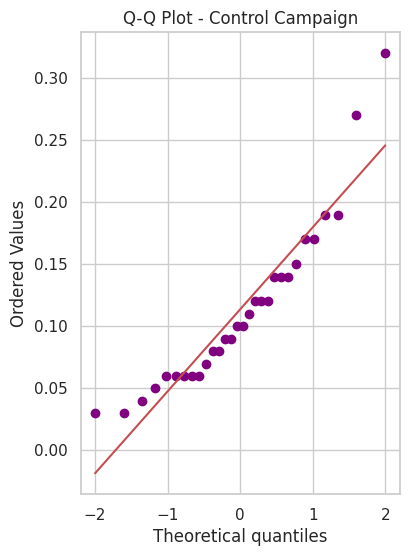

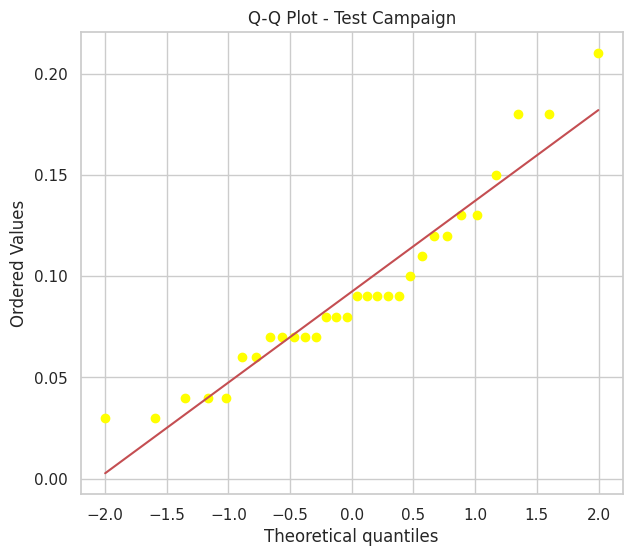

In [ ]:
for metric in metrics:
    # Set up the matplotlib figure
    plt.figure(figsize=(14, 6))

    # Q-Q Plot for Control Campaign
    plt.subplot(1, 3, 3)
    stats.probplot(control_data['CR'], dist="norm", plot=plt)
    plt.gca().get_lines()[0].set_color('purple')
    plt.title('Q-Q Plot - Control Campaign')

    # Q-Q Plot for Test Campaign
    plt.figure(figsize=(7, 6))
    stats.probplot(test_data['CR'], dist="norm", plot=plt)
    plt.gca().get_lines()[0].set_color('yellow')
    plt.title('Q-Q Plot - Test Campaign')

💡 Since all the dots generally follow the straight line y = x, we can conclude that the sample distribution is similar to the theoretical one

**Step 4:** Aggregate Data by Campaign
For each metric, aggregate the data by Campaign Name:

Total Spend
Total Impressions
Total Website Clicks
Total Purchases

Calculate the average for each metric within each campaign.

In [ ]:
# Combine the two datasets
combined_df = pd.concat([control_data, test_data], ignore_index=True)

combined_df.head()

,Campaign Name,Date,Spend,Impressions,Reach,Website Clicks,Searches,View Content,Add to Cart,Purchases,CR,CPC,CPP,CTR
0,Control Campaign,1.08.2019,2280,82702.00,56930.00,7016.00,2290.00,2159.00,1819.00,618.00,0.09,0.32,3.69,0.08
1,Control Campaign,2.08.2019,1757,121040.00,102513.00,8110.00,2033.00,1841.00,1219.00,511.00,0.06,0.22,3.44,0.07
2,Control Campaign,3.08.2019,2343,131711.00,110862.00,6508.00,1737.00,1549.00,1134.00,372.00,0.06,0.36,6.30,0.05
3,Control Campaign,4.08.2019,1940,72878.00,61235.00,3065.00,1042.00,982.00,1183.00,340.00,0.11,0.63,5.71,0.04
4,Control Campaign,5.08.2019,1835,109559.80,88844.90,5320.80,2221.30,1943.80,1300.00,522.80,0.10,0.34,3.51,0.05


In [ ]:
# Aggregate data by Campaign Name
aggregated_data = combined_df.groupby('Campaign Name').agg({
    'Spend': 'sum',
    'Impressions': 'sum',
    'Website Clicks': 'sum',
    'Purchases': 'sum'
}).reset_index()

# Calculate average metrics
aggregated_data['Average Spend'] = aggregated_data['Spend'] / 30
aggregated_data['Average Impressions'] = aggregated_data['Impressions'] / 30
aggregated_data['Average Website Clicks'] = aggregated_data['Website Clicks'] / 30
aggregated_data['Average Purchases'] = aggregated_data['Purchases'] / 30

aggregated_data.head()

,Campaign Name,Spend,Impressions,Website Clicks,Purchases,Average Spend,Average Impressions,Average Website Clicks,Average Purchases
0,Control Campaign,68653,3286792.80,159623.80,15683.80,2288.43,109559.76,5320.79,522.79
1,Test Campaign,76892,2237544.00,180970.00,15637.00,2563.07,74584.80,6032.33,521.23


<ipython-input-67-840cc27132a2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Campaign Name', y='Average Spend', data=aggregated_data, palette=['purple', 'yellow'])
<ipython-input-67-840cc27132a2>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Campaign Name', y='Average Impressions', data=aggregated_data, palette=['purple', 'yellow'])
<ipython-input-67-840cc27132a2>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Campaign Name', y='Average Website Clicks', data=aggregated_data, palette=['purple', 'yellow'])
<ipython-input-67

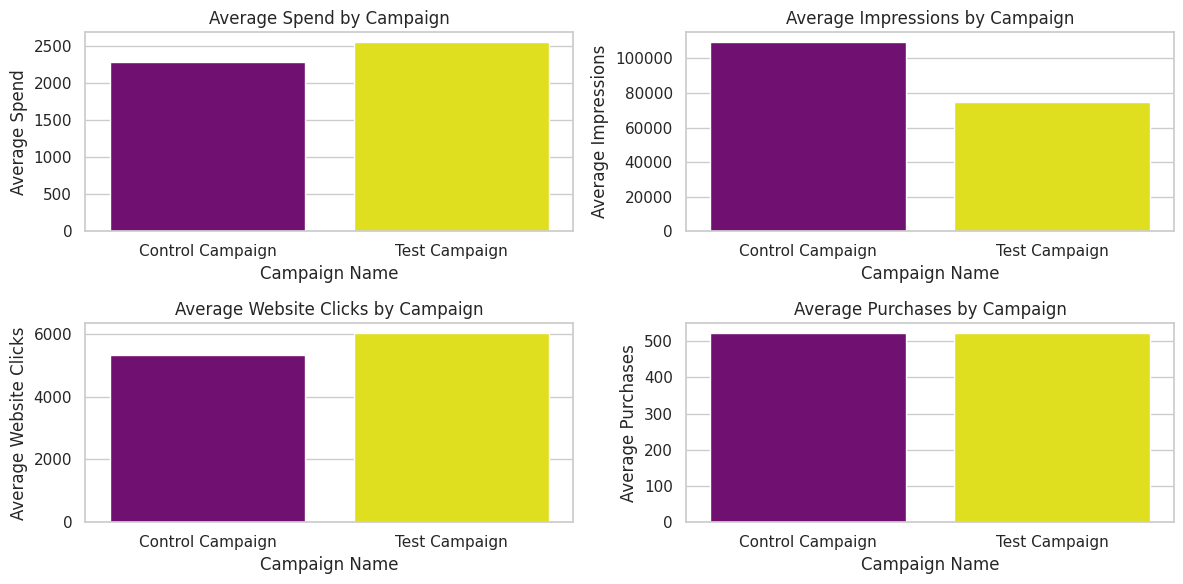

In [ ]:
# Plot average metrics
plt.figure(figsize=(12, 6))

# Plot Average Spend
plt.subplot(2, 2, 1)
sns.barplot(x='Campaign Name', y='Average Spend', data=aggregated_data, palette=['purple', 'yellow'])
plt.title('Average Spend by Campaign')

# Plot Average Impressions
plt.subplot(2, 2, 2)
sns.barplot(x='Campaign Name', y='Average Impressions', data=aggregated_data, palette=['purple', 'yellow'])
plt.title('Average Impressions by Campaign')

# Plot Average Website Clicks
plt.subplot(2, 2, 3)
sns.barplot(x='Campaign Name', y='Average Website Clicks', data=aggregated_data, palette=['purple', 'yellow'])
plt.title('Average Website Clicks by Campaign')

# Plot Average Purchases
plt.subplot(2, 2, 4)
sns.barplot(x='Campaign Name', y='Average Purchases', data=aggregated_data, palette=['purple', 'yellow'])
plt.title('Average Purchases by Campaign')

plt.tight_layout()
plt.show()

Filter with code Test and Control Campaign

💡 Only Average Website Clicks is better for Test Campaign in comparison with Control Campaign.

**Step 5.** Hypothesis Testing:

Null Hypothesis (H0): There is no significant difference between the performance of the Control Campaign and the Test Campaign.
Alternative Hypothesis (H1): There is a significant difference between the performance of the Control Campaign and the Test Campaign.

In [ ]:
for metric in metrics:
    ## Homogeneity of Variances - Levene's Test
    levene_test = stats.levene(control_data[metric], test_data[metric])
    print("\nLevene's Test for Homogeneity of Variances")
    print(f"Statistic={levene_test.statistic}, p-value={levene_test.pvalue}")


Levene's Test for Homogeneity of Variances
Statistic=2.656358773311839, p-value=0.1085562119294894

Levene's Test for Homogeneity of Variances
Statistic=0.21933257067417042, p-value=0.6413042472737659

Levene's Test for Homogeneity of Variances
Statistic=1.787402224921058, p-value=0.18646335237594522

Levene's Test for Homogeneity of Variances
Statistic=9.675049270792272, p-value=0.002895597403202903


Since

*   the analized data is normally distributed, and
*   based on the results of Levene's Test for Homogeneity of Variances we can   assume equal variance

we'll use two-sample t-test to compare the means of the two campaigns.

## Marketing Intelligenece Lab

In [ ]:
# Calculate the correlation matrix

control_data = ["Spend", "Impressions", "Reach", "Website Clicks", "Searches", "View Content", "Add to Cart","Purchases"]

combined_df = combined_df[control_data]
correlation_matrix = combined_df.corr()

# Extract the correlation of the features with 'Purchase'
correlation_with_purchase = correlation_matrix['Purchases']

<Axes: >

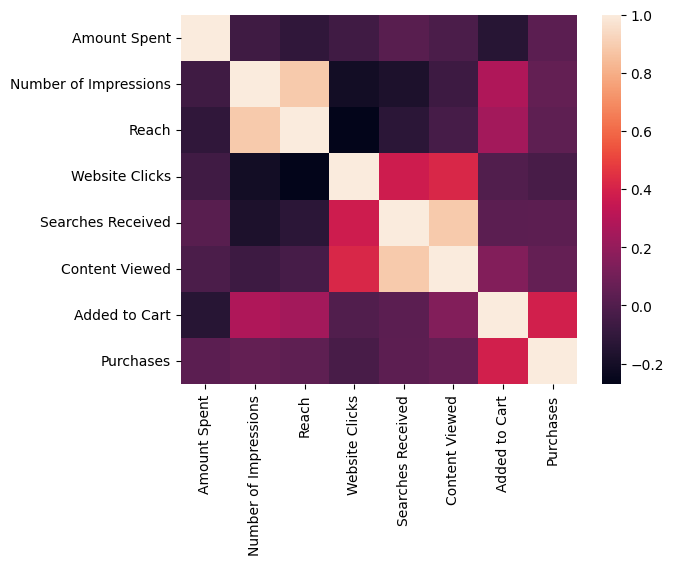

In [ ]:
import seaborn as sns
sns.heatmap(correlation_matrix)

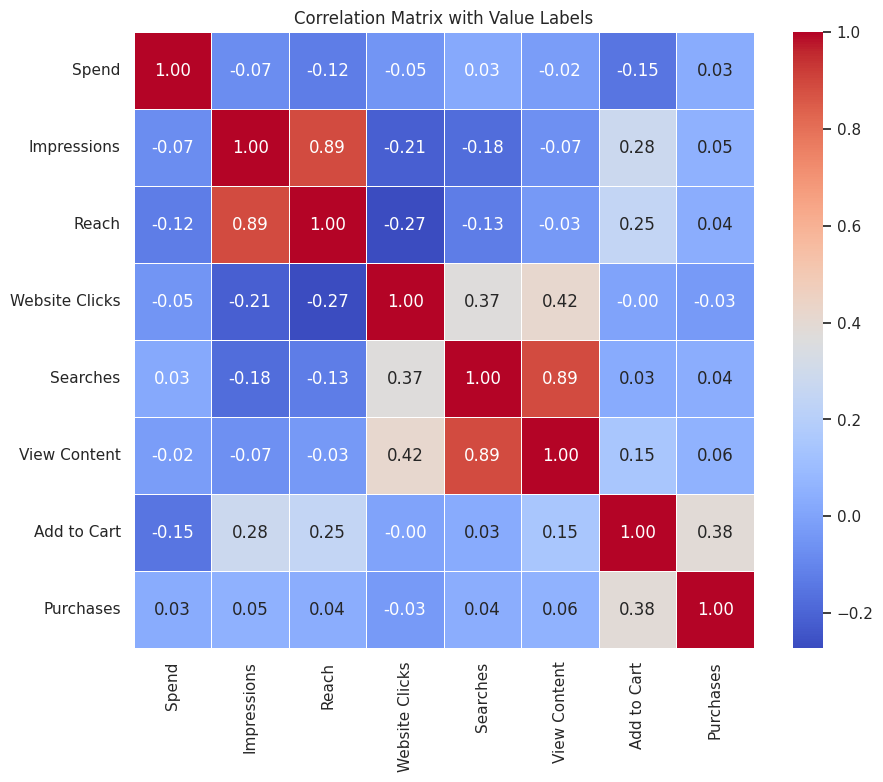

In [ ]:

# Create a heatmap with value labels
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix with Value Labels')
plt.show()


In [ ]:
from scipy import stats

control_conversion_rates = control_data['CR']
test_conversion_rates = test_data['CR']

# Perform t-test
t_stat, p_value = stats.ttest_ind(control_conversion_rates, test_conversion_rates)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 1.441938908989866, P-value: 0.15469778621621894


The p-value of 0.155 is greater than the common significance level of 0.05. This suggests that the difference in conversion rates between the control and test campaigns is not statistically significant.

In [ ]:
from scipy import stats

control_cost_per_click = control_data['CPC']
test_cost_per_click = test_data['CPC']

# Perform t-test
t_stat, p_value = stats.ttest_ind(control_cost_per_click, test_cost_per_click)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 0.41457597197949464, P-value: 0.6799817291218537


The p-value of 0.68 is greater than the common significance level of 0.05. This suggests that the difference in cost per click between the control and test campaigns is not statistically significant.

In [ ]:
from scipy import stats

control_cost_per_purchase = control_data['CPP']
test_cost_per_purchase = test_data['CPP']

# Perform t-test
t_stat, p_value = stats.ttest_ind(control_cost_per_purchase, test_cost_per_purchase)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.4061941519455945, P-value: 0.16500161293480364


The p-value of 0.165 is greater than the common significance level of 0.05. This suggests that the difference in cost per perchase between the control and test campaigns is not statistically significant.

In [ ]:
from scipy import stats

control_cost_through_rate = control_data['CTR']
test_cost_through_rate = test_data['CTR']

# Perform t-test
t_stat, p_value = stats.ttest_ind(control_cost_through_rate, test_cost_through_rate)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -3.957114947612694, P-value: 0.00020933279582000514


The p-value of 0.000209 indicates that the difference in cost-through rate between the control and test campaigns is statistically significant.



Since for CTR score the p-value is significantly less than 0.05, we should consider using a statistical test that does not assume equal variances, such as **Welch’s t-test**, to account for the **unequal** variances.

In [ ]:
# Perform Welch's t-test
t_stat, p_value = stats.ttest_ind(control_cost_through_rate, test_cost_through_rate, equal_var=False)

print(f"Welch's t-test")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

Welch's t-test
T-statistic: -3.957114947612694
P-value: 0.0003638812121363673


The p-value of 0.00036 indicates that the difference in cost-through rate between the control and test campaigns is statistically significant.

Let's onsider whether it might be practically significant. This involves looking at the effect size (e.g., Cohen’s d) and considering the context of the results.

In [ ]:
# Calculate means and standard deviations
mean_control = np.mean(control_cost_through_rate)
std_control = np.std(control_cost_through_rate, ddof=1)
n_control = len(control_cost_through_rate)

mean_test = np.mean(test_cost_through_rate)
std_test = np.std(test_cost_through_rate, ddof=1)
n_test = len(test_cost_through_rate)

# Calculate pooled standard deviation
pooled_std = np.sqrt(((n_control - 1) * std_control**2 + (n_test - 1) * std_test**2) / (n_control + n_test - 2))

# Calculate Cohen's d
cohen_d = (mean_control - mean_test) / pooled_std

print(f"Mean of Control Group: {mean_control}")
print(f"Standard Deviation of Control Group: {std_control}")
print(f"Mean of Test Group: {mean_test}")
print(f"Standard Deviation of Test Group: {std_test}")
print(f"Pooled Standard Deviation: {pooled_std}")
print(f"Cohen's d: {cohen_d}")

Mean of Control Group: 0.05100000000000002
Standard Deviation of Control Group: 0.020401149392907353
Mean of Test Group: 0.10233333333333333
Standard Deviation of Test Group: 0.06806099360554996
Pooled Standard Deviation: 0.05024194336969081
Cohen's d: -1.0217226860754933


The Cohen's d of -1.02 indicates a large effect size, suggesting a substantial difference between the performance of the test and control groups. While this difference is statistically significant and potentially meaningful, it is crucial to interpret it within the context of our business objectives. In this ad campaign, key performance metrics such as Conversion Rate, Cost per Click, and Cost per Purchase are more relevant than the Click-through Rate.

Despite the large effect size, the observed differences in these critical metrics between the control and test campaigns are not statistically significant. Therefore, we do not have sufficient evidence to conclude that the test ad campaign performed better than the control. As a result, we fail to reject the null hypothesis, indicating that the new ad variant did not achieve a significant improvement in the desired business outcomes.

Based on the analysis, the test group had a higher mean value compared to the control group (0.102 vs. 0.051), with a Cohen's d of -1.02 indicating a large effect size. However, despite this large effect in terms of Click-through Rate (CTR), the key business metrics like Conversion Rate, Cost per Click (CPC), and Cost per Purchase (CPP) showed no statistically significant differences between the test and control groups. As a result, the new ad variant (test) did not lead to substantial improvements in the desired business outcomes.



**Recommendation**

Given that the observed difference in key metrics is not statistically significant, I recommend maintaining the control ad variant. The test campaign, while showing an increased CTR, did not demonstrate meaningful improvements in critical performance areas such as conversion rates or costs, which are more directly tied to business success.